In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
listings = pd.read_csv('data_procesada/listings.csv', index_col=0)
listings.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,availability_365
0,4,60,40.45724,-3.67688,2,50,1,78,180
1,9,44,40.40341,-3.74084,2,31,4,33,364
2,0,67,40.38695,-3.69304,0,50,15,0,347
3,3,117,40.42202,-3.70395,0,92,5,10,88
4,3,65,40.41995,-3.69764,0,115,3,68,358


In [3]:
listings.shape

(20156, 9)

In [4]:
listings.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'availability_365'],
      dtype='object')

In [5]:
## quitamos outliers para buscar un mejor score

In [6]:
max_thresold = listings['price'].quantile(0.95)
max_thresold
## esto significa que cualquier cosa por encima de esto lo podemos considerar outlier

350.0

In [7]:
outliers = listings[listings['price'] > max_thresold]
outliers
## aqui tengo a los outliers

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,availability_365
9,3,83,40.41980,-3.71078,0,1400,3,0,365
48,3,117,40.42762,-3.70323,0,9999,5,24,42
453,3,50,40.41179,-3.69813,0,510,2,1,83
506,14,68,40.42969,-3.67649,0,364,3,1,362
567,3,117,40.42692,-3.70495,2,400,3,55,0
...,...,...,...,...,...,...,...,...,...
19985,3,114,40.41539,-3.70634,0,618,1,0,364
19990,3,50,40.40968,-3.70533,0,1567,1,0,287
20100,5,102,40.44068,-3.69487,0,1498,1,0,364
20124,3,40,40.41637,-3.69650,0,469,1,0,352


In [8]:
outliers.shape

(992, 9)

In [9]:
## y le decimos al pc que nos quedamos con la data que este por debajo de ese max_thresold

In [10]:
listings_normales = listings[(listings['price'] <= max_thresold)]
listings_normales.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,availability_365
0,4,60,40.45724,-3.67688,2,50,1,78,180
1,9,44,40.40341,-3.74084,2,31,4,33,364
2,0,67,40.38695,-3.69304,0,50,15,0,347
3,3,117,40.42202,-3.70395,0,92,5,10,88
4,3,65,40.41995,-3.69764,0,115,3,68,358


In [11]:
listings_normales.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'availability_365'],
      dtype='object')

In [12]:
listings_normales.shape

(19164, 9)

In [13]:
19164+992
## el primero numero es listings_normales el segundo son los outliers

20156

In [14]:
result_dict = {} 

In [15]:
##esto nos ayudara a poner diferentes modelos y printearlos: helper function
def build_model(regression_fn, ## aqui meto la función de regresión
                  name_of_y_col, ## aquí va price
                  names_of_x_cols, ## aquí el resto
                  dataset,
                  test_frac=0.2,
                  preprocess_fn=None, #si quiero data estandarizada
                  show_plot_Y=False,
                  show_plot_scatter=False):
        
        X = dataset[names_of_x_cols]
        Y = dataset[name_of_y_col]
        
        if preprocess_fn is not None:
            X = preprocess_fn(X)
            
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_frac)
        
        model = regression_fn(x_train, y_train) # modelo entrenado
        
        y_pred = model.predict(x_test) #modelo testeado
        
        print("Training_score: " ,  model.score(x_train, y_train))
        print("Test_score :" , r2_score(y_test, y_pred))
        
        if show_plot_Y == True:
            fig, ax = plt.subplots(figsize=(12,8))
            
            plt.plot(y_pred, label="Predicted")
            plt.plot(y_test.values, label="Actual")
            
            plt.ylabel(name_of_y_col)
            
            plt.legend()
            plt.show()
        if show_plot_scatter == True:
            fig, ax = plt.subplots(figsize=(12,8))
            
            plt.scatter(x_test, y_test)
            plt.plot(x_test, y_test, "r")
            
            plt.legend(["Predicted Line", "Observed Data"])
            plt.show()
        return {
            "Training_score": model.score(x_train, y_train),
            "Test_score": r2_score(y_test, y_pred)
        }

In [59]:
# aqui estamos en un for loop que te da el tipo de regresion y los scores de train y test
def compare_results():

    for key in result_dict:
        print("Regression: ", key)
        print("Training score", result_dict[key]["Training_score"])
        print("Test score", result_dict[key]["Test_score"])
        print()

In [16]:
def linear_reg(x_train, y_train):
    model = LinearRegression(normalize=True)
    model.fit(x_train, y_train)
    
    return model

## Linear Regression

Training_score:  0.16099976140892347
Test_score : 0.16631255438684978


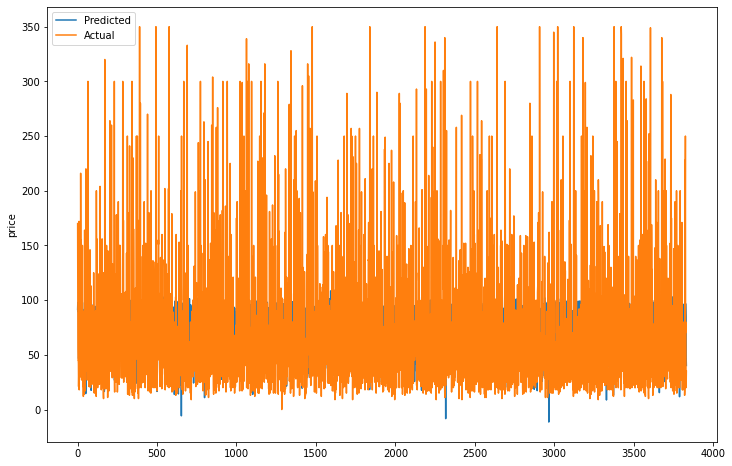

{'Training_score': 0.16099976140892347, 'Test_score': 0.16631255438684978}

In [22]:
## con las helper funcitons de arriba voy cambiando de modelos
build_model(linear_reg,
            'price',
            ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
            'room_type', 'minimum_nights', 'number_of_reviews','availability_365'],
                                                  listings_normales, ## la dataset
                                                  show_plot_Y=True) ## para ver la gráfica

## LASSO

In [23]:
def lasso_reg(x_train, y_train, alpha=0.5): # alpha value by default = 1, alpha implica regularización
                                      ## alpha=0 no tiene penalry
    model = Lasso(alpha=alpha)
    model.fit(x_train, y_train)
    
    return model

In [25]:
build_model(lasso_reg, 
            'price',
         ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews','availability_365'],
                                                  listings_normales,
                                                  show_plot_Y=False)

Training_score:  0.15456923202418527
Test_score : 0.16461083111907415


{'Training_score': 0.15456923202418527, 'Test_score': 0.16461083111907415}

## RIDGE

In [26]:
def ridge_reg(x_train, y_train, alpha=0.5, normalize=True):
    model = Ridge(alpha=alpha, normalize=normalize)
    model.fit(x_train, y_train)
    
    return model

In [27]:
build_model(ridge_reg,
            'price',
        ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews','availability_365'],
                                                  listings_normales,
                                                  show_plot_Y=False)

Training_score:  0.1361929067015344
Test_score : 0.16228636804499885


{'Training_score': 0.1361929067015344, 'Test_score': 0.16228636804499885}

## Elastic Net

In [28]:
def elastic_net_reg(x_train, y_train, alpha=1, l1_ratio=0.5, 
                   normalize=False, max_iter= 100000, warm_start=True, equivalent_to="Elastic Net"):
    print("Equivalent to: ", equivalent_to)
    
    model= ElasticNet(alpha=alpha, l1_ratio=l1_ratio,
                     normalize=normalize, max_iter=max_iter, warm_start=warm_start)
    model.fit(x_train, y_train)
    
    return model

In [30]:
from functools import partial ## con esta funcion podemos cambiar el l1_ratio como nosotros queramos

In [31]:
build_model(partial(elastic_net_reg, alpha=1, l1_ratio=0.5),
                                                            'price',
                                                          ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews','availability_365'],
                                                            listings_normales,
                                                            show_plot_Y=False)

Equivalent to:  Elastic Net
Training_score:  0.1355187007849823
Test_score : 0.1468490162947902


{'Training_score': 0.1355187007849823, 'Test_score': 0.1468490162947902}

## SUPPORT VECTOR REGRESSOR (tarda mas en pensar)

In [33]:
def svr_reg(x_train, y_train, kernel="linear", epsilon=0.05, C=0.3):
    model = SVR(kernel=kernel, epsilon = epsilon, C=C)
    model.fit(x_train, y_train)
    
    return model

In [34]:
build_model(svr_reg,
           'price',
       ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews','availability_365'],
                                                            listings_normales,
                                                            show_plot_Y=False)

Training_score:  0.08402384776424654
Test_score : 0.07392791875372728


{'Training_score': 0.08402384776424654, 'Test_score': 0.07392791875372728}

## Nearest Neighbors Regression

In [36]:
def kneighbors_reg(x_train, y_train, n_neighbors=10): ## the number of neighbors depends but is 5 by default
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(x_train, y_train)
    
    return model

In [37]:
build_model(kneighbors_reg,
               'price',
       ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews','availability_365'],
                                                            listings_normales,
                                                            show_plot_Y=False)

Training_score:  0.22472567890267758
Test_score : 0.04867186621908903


{'Training_score': 0.22472567890267758, 'Test_score': 0.04867186621908903}

 ##  Stockastic Gradient Descent Regression

In [39]:
def apply_standard_scaler(x):
    scaler = StandardScaler()
    scaler.fit(x)
    
    return scaler.transform(x)

In [40]:
def sgd_reg(x_train, y_train, max_iter=10000, tol=1e-3): ## tolerance cuando no mejora mas que la tolernacia para
    model = SGDRegressor(max_iter=max_iter, tol=tol)
    model.fit(x_train, y_train)
    
    return model

In [41]:
build_model(sgd_reg,
            'price',
          ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews','availability_365'],
                                                            listings_normales,
                                                            show_plot_Y=False,
                                 preprocess_fn=apply_standard_scaler)

Training_score:  0.15618225861229895
Test_score : 0.17852580150276642


{'Training_score': 0.15618225861229895, 'Test_score': 0.17852580150276642}

## Decision Tree

In [43]:
def decision_tree_reg(x_train, y_train, max_depth=2):
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(x_train, y_train)
    
    return model

In [44]:
build_model(decision_tree_reg,
              'price',
       ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews','availability_365'],
                                                            listings_normales,
                                                            show_plot_Y=False)

Training_score:  0.17978074898824548
Test_score : 0.18403070169450297


{'Training_score': 0.17978074898824548, 'Test_score': 0.18403070169450297}

In [45]:
## no tenemos buenos resultados con ninguno

### DECISION TREE HYPERPARAMETERS TUNNING

In [46]:
X = listings_normales.drop(["price"], axis=1)

Y = listings_normales["price"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [47]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[1, 2, 3, 4, 5, 7, 8]}

grid_search = GridSearchCV(decision_tree_reg(x_train, y_train), parameters, cv=3, return_train_score=True)
grid_search.fit(x_train, y_train)

grid_search.best_params_

{'max_depth': 4}

In [48]:
def decision_tree_reg(x_train, y_train, max_depth=4):
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(x_train, y_train)
    
    return model

In [49]:
build_model(decision_tree_reg,
                 'price',
          ['latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews','availability_365'],
                                                            listings_normales,
                                                            show_plot_Y=False)

Training_score:  0.21673076974890448
Test_score : 0.21144386607710763


{'Training_score': 0.21673076974890448, 'Test_score': 0.21144386607710763}

In [50]:
## lo mejora algo pero no acaba de ser buen modelo

## Ensemble metods: Random Forest && Extra Tree

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
rnd_reg = RandomForestRegressor(n_estimators=600, max_leaf_nodes=12, n_jobs=-1)

In [53]:
type(rnd_reg)

sklearn.ensemble._forest.RandomForestRegressor

In [54]:
rnd_reg.fit(x_train, y_train)

RandomForestRegressor(max_leaf_nodes=12, n_estimators=600, n_jobs=-1)

In [55]:
y_pred = rnd_reg.predict(x_test)

In [56]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.22847895476720415

In [57]:
important_features = pd.Series(rnd_reg.feature_importances_, index=X.columns).\
                        sort_values(ascending=False)

important_features

room_type              0.615004
latitude               0.119777
number_of_reviews      0.117752
longitude              0.069803
minimum_nights         0.059588
availability_365       0.008505
neighbourhood          0.005776
neighbourhood_group    0.003796
dtype: float64

In [58]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [59]:
bag_reg = BaggingRegressor(DecisionTreeRegressor(splitter="random", max_leaf_nodes = 12),
                          n_estimators=600,
                          bootstrap=True,
                          max_samples=1.0,
                          n_jobs=-1)
bag_reg.fit(x_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes=12,
                                                      splitter='random'),
                 n_estimators=600, n_jobs=-1)

In [60]:
y_pred = bag_reg.predict(x_test)

r2_score(y_test, y_pred)

0.1982156302083683

In [61]:
from sklearn.ensemble import ExtraTreesRegressor

In [62]:
extra_reg = ExtraTreesRegressor(n_estimators=600, max_leaf_nodes=12, n_jobs=-1)

extra_reg.fit(x_train, y_train)

ExtraTreesRegressor(max_leaf_nodes=12, n_estimators=600, n_jobs=-1)

In [63]:
y_pred = extra_reg.predict(x_test)

In [64]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.19948706685186424